In [60]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import imageio
import matplotlib as mpl
import itertools
import os
import os.path
import glob
import sys
import shutil
% matplotlib inline

# Dataset & Utils
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from torchvision.utils import save_image

# Optimizer, Functions, Distributions
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim
from torch import nn 
import torch.distributions as ds


# My models, optimizer classes - VAE, Adam
import nldr.models
from nldr.models import vae, Encoder, Decoder, VAE
from nldr.models import optimizers, Optimizer
import nldr.utils
from nldr.utils.datasets import MNIST_Loader, Visualize, Caltech256, Caltech256_Loader

# Unrelated but useful
get_types = lambda x :[(a, getattr(x, a)) for a in dir(x) if not callable(getattr(x, a)) and a[0] != '_']

Something wrong with the caltech loader, fails when calling .iter() the second time.. 

In [62]:
for cat in range(1, 258):
    cat_dirs = glob.glob(os.path.join('data', '256_ObjectCategories', '%03d*' % cat))
    filenames = [f for f in os.listdir(cat_dirs[0])]
    
    split_1 = int(0.4 * len(filenames))
    train_filenames = filenames[:split_1]
    test_filenames = filenames[split_1:]
    
    # Create folders train and test 
    os.mkdir(os.path.join(cat_dirs[0],'train'))
    os.mkdir(os.path.join(cat_dirs[0],'test'))
    for f in train_filenames:
        shutil.move(os.path.join(cat_dirs[0],f), os.path.join(cat_dirs[0],'train'))
    for f in test_filenames:
        shutil.move(os.path.join(cat_dirs[0],f), os.path.join(cat_dirs[0],'test'))


In [63]:
# Can always add this to the Loader class and abstract the loading aspect of it, leave here for now. 
cal_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
cal_transform1 = transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

caltech_train = Caltech256(root='./data',max_items = 30, download=False, transform=cal_transform)

In [73]:
caltech_train

Dataset Caltech256
    Number of datapoints: 7680
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                         )
    Target Transforms (if any): None

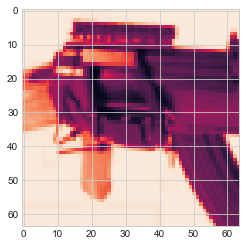

In [64]:
#plt.imshow(caltech_train[5][0][0])

In [65]:
caltech_test = Caltech256(root='./data',max_items = 40, train = False, download=False, transform=cal_transform)

In [66]:
len(caltech_test)

10240

In [67]:
caltech_X_train = []
caltech_Y_train = []

caltech_X_test = []
caltech_Y_test = []

In [68]:
for (i,item) in enumerate(caltech_train):
        img = item[0][0].numpy().reshape(-1)
        caltech_X_train.append(img)
        caltech_Y_train.append(item[1])
for (i,item) in enumerate(caltech_test):
        img = item[0][0].numpy().reshape(-1)
        caltech_X_test.append(img)
        caltech_Y_test.append(item[1])

In [69]:
#SIFT Descriptor? What about the channels?
X_train = np.asarray(caltech_X_train)
Y_train = np.asarray(caltech_Y_train)

X_test = np.asarray(caltech_X_test)
Y_test = np.asarray(caltech_Y_test)

In [70]:
np.save("data/caltech256_X_train"+".npy",X_train)
np.save("data/caltech256_Y_train"+".npy",Y_train)

np.save("data/caltech256_X_test"+".npy",X_test)
np.save("data/caltech256_Y_test"+".npy",Y_test)

In [90]:
caltech_train_loader = Caltech256_Loader(dataset=caltech_train).load(batch_size=100)
cal_iter = iter(caltech_train_loader)

In [91]:
val = cal_iter.next()
labels = val[1]
images = val[0]

In [95]:
caltech_train_loader.dataset

Dataset Caltech256
    Number of datapoints: 7680
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                         )
    Target Transforms (if any): None

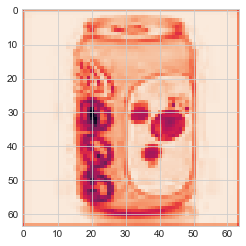

In [84]:
rand_image = Caltech256_Loader(dataset=caltech_train).random_image(images)
# Should be normalized? 
plt.imshow(rand_image)

In [ ]:
labels

In [96]:
#train_loader, test_loader = MNIST_Loader(batch_size=64).load()
train_loader, test_loader = MNIST_Loader().load(batch_size=100)

In [ ]:
# Why am I not able to reload specific class without restarting kernel? Is it specifically because it's a class and not a method?
import importlib
importlib.reload(nldr.utils)
importlib.reload(nldr.models);

In [100]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [98]:
rand_image = MNIST_Loader().random_image(images)

In [ ]:
Visualize.imshow_batch(images)
#Visualize.display_labels(classes,labels)

# Visualize a random digit from a batch
#Visualize.imshow_random(images)

### VAE Encoder/Decoder architecture

In [ ]:
D_in, H, D_out = 784, 500, 2
encoder = Encoder(D_in, H, D_out)
decoder = Decoder(D_out, H, D_in)

In [ ]:
#model_vae = VAE().to(device) - if cuda is available, but not the case, yet
model_vae = VAE(encoder,decoder)
optimizer = Optimizer(model_vae,optimizer = optim.Adam(model_vae.parameters(), lr=1e-4),early_stopping = True)
#optim.RMSprop(model_vae.parameters(), lr = 1e-3, momentum=0.9)

In [ ]:
# Generate 64 different digits. The sample is just the mean.
# Turn on early stopping
epochs = 30
for epoch in range(1, epochs + 1):
    optimizer.train_epoch(epoch,train_loader)
    optimizer.test_epoch(epoch,test_loader)
    
    with torch.no_grad():
        sample = torch.randn(64, D_out)
        sample = model_vae.decode(sample)
        save_image(sample.view(64, 1, 28, 28),
                   'MNIST_VAE_results/sample_' + str(epoch) + '.png')
        
    if optimizer.early_stopping and epoch>3:
        diff = np.abs(optimizer.average_loss[-1] - optimizer.average_loss[-3])
        thres = diff/optimizer.average_loss[-1] * 100
        if thres<= 0.3:
            print("Performing early stopping .. ")
            break;    

## Model Evaluation

### Optimizer stats

In [ ]:
optimizer.show_stats(show=True,save=True)

### Save Model and Gifs

In [ ]:
torch.save(model_vae.state_dict(), "data/saved" + '/VAE_Adam_1e-4_30epochs.pkl')
# ... after training, save your model 
#model.save_state_dict('mytraining.pt')
# .. to load your previously training model:
#model.load_state_dict(torch.load('mytraining.pt'))

In [ ]:
image_gif = Visualize.make_gif(30)

### Load Model
    * Model needs to exist first

In [ ]:
model_original = torch.load(f="data/saved" + '/VAE_Adam_1e-4_30epochs.pkl')
model_vae_original = VAE(encoder,decoder)
model_vae_original.load_state_dict(model_original)

### Plot the latent space
    * First change the number of points you plot by selecting 10000 

In [ ]:
train_loader, test_loader = MNIST_Loader().load(batch_size=10000)

dataiter = iter(train_loader)
images, labels = dataiter.next()

# Feed a new batch of images and get the mean and logvar of the latent space. 
# This gives you the parameters of the Gaussian
mu, logvar = model_vae.encode(images.view(-1, 784)) 
Visualize.plot_latent_space(mu,labels)
# 2. Visualize the prior predictive distribution. Fix the latent variables between [-3,3]

### Plot the manifold
    * Generate the 2 dimensions by encoding a digit of your choice, then perturb the reconstruction with linspace
    * Plot the 2 latent dimensions/means in space with the associated digits they produce

In [ ]:
n = np.linspace(-1, 1, 15)
no_digit = 2

img = images[no_digit]
label = labels[no_digit]

In [ ]:
Visualize.plot_manifold(model_vae, n, img, label)

# Proof it's random but not entirely, when you generate
#Visualize.imshow_batch(res.view(-1,28,28).data)
#Visualize.imshow_batch(res1.view(-1,28,28).data)

# Latent Space Reduction

In [ ]:
# This is an example that aims to further reduce the latent space. 
latent_data = LatentSpaceDataset(mu,labels)
mini_train_loader = DataLoader(dataset=latent_data, batch_size = 100, shuffle=True)

#mini_data_iter = iter(mini_train_loader)
#datapoint, label = mini_data_iter.next()
D_in_latent, H_latent, D_out_latent = 20, 10, 2
encoder1 = Encoder(D_in_latent, H_latent, D_out_latent)
decoder1 = Decoder(D_out_latent, H_latent, D_in_latent)

#model_vae = VAE().to(device) - if cuda is available, but not the case, yet
model = VAE(encoder1,decoder1)
optimizer1 = Optimizer(model,optimizer = optim.Adam(model.parameters(), lr=1e-3))

# Generate 64 different digits. The sample is just the mean.
epochs = 15
for epoch in range(1, epochs + 1):
    optimizer1.train_epoch(epoch,mini_train_loader)
    #optimizer1.test_epoch(epoch,test_loader)
    
mu_latent, logvar_latent = model.encode(mu.view(-1,20))    
plot_latent_space(mu_latent,labels)